In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle

# Extract Features from Wave Files

In [2]:
#directory to training data and json file
train_dir2='/home/aka/Documents/nsynth-train/audio/'
#directory to training data and json file
valid_dir2='/home/aka/Documents/nsynth-valid/audio/'
#directory to training data and json file
test_dir2='/home/aka/Documents/nsynth-test/audio/'

In [1]:
"""
#directory to training data and json file
train_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-train/audio/'
#directory to training data and json file
valid_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-valid/audio/'
#directory to training data and json file
test_dir='/Users/nadimkawwa/Desktop/Udacity/MLEND/Capstone/nsynth-test/audio/'
""";

- Number of Zero Crossings
- max mean mfcc
- centroid mean
- centroid std
- centroid skewness
- max mean contrast
- rolloff mean
- rolloff std
- rolloff skewness
- zero crossing rate mean
- zero crossing rate std
- zero crossing rate skewness

In [4]:
#read the raw json files as given in the training set
df_train_raw2 = pd.read_json(path_or_buf='nsynth-train/examples.json', orient='index')

In [5]:
#Get a count of instruments in ascending order
n_class_train2 = df_train_raw2['instrument_family'].value_counts(ascending=True)
n_class_train2

9      5501
2      8773
10    10208
1     12675
7     13911
8     19474
3     32690
5     34201
6     34477
4     51821
0     65474
Name: instrument_family, dtype: int64

In [6]:
#Sample n files
df_train_sample2=df_train_raw2.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(5000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample2= df_train_sample2[df_train_sample2['instrument_family']!=9]

In [7]:
df_train_sample2.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_142-049-127,118160,16000,49,2,bass,bass_synthetic_142,bass_synthetic_142-049-127,[],synthetic,127,0,951,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_122-084-127,199722,16000,84,2,bass,bass_synthetic_122,bass_synthetic_122-084-127,[percussive],synthetic,127,0,888,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
bass_electronic_009-052-075,145330,16000,52,1,bass,bass_electronic_009,bass_electronic_009-052-075,[],electronic,75,0,565,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_124-060-050,194458,16000,60,2,bass,bass_synthetic_124,bass_synthetic_124-060-050,[tempo-synced],synthetic,50,0,893,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
bass_synthetic_037-084-127,203074,16000,84,2,bass,bass_synthetic_037,bass_synthetic_037-084-127,"[distortion, long_release]",synthetic,127,0,443,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0]"


In [8]:
print(df_train_sample2.shape)

(50000, 13)


In [9]:
print(df_train_sample2["instrument_family_str"].unique())

['bass' 'brass' 'flute' 'guitar' 'keyboard' 'mallet' 'organ' 'reed'
 'string' 'vocal']


In [10]:
df_train_sample2 = df_train_sample2[df_train_sample2["instrument_family_str"] != 'reed']
print(df_train_sample2["instrument_family_str"].unique())
df_train_sample2.head()

['bass' 'brass' 'flute' 'guitar' 'keyboard' 'mallet' 'organ' 'string'
 'vocal']


,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_142-049-127,118160,16000,49,2,bass,bass_synthetic_142,bass_synthetic_142-049-127,[],synthetic,127,0,951,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_122-084-127,199722,16000,84,2,bass,bass_synthetic_122,bass_synthetic_122-084-127,[percussive],synthetic,127,0,888,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
bass_electronic_009-052-075,145330,16000,52,1,bass,bass_electronic_009,bass_electronic_009-052-075,[],electronic,75,0,565,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_124-060-050,194458,16000,60,2,bass,bass_synthetic_124,bass_synthetic_124-060-050,[tempo-synced],synthetic,50,0,893,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
bass_synthetic_037-084-127,203074,16000,84,2,bass,bass_synthetic_037,bass_synthetic_037-084-127,"[distortion, long_release]",synthetic,127,0,443,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0]"


In [11]:
df_train_sample2.shape

(45000, 13)

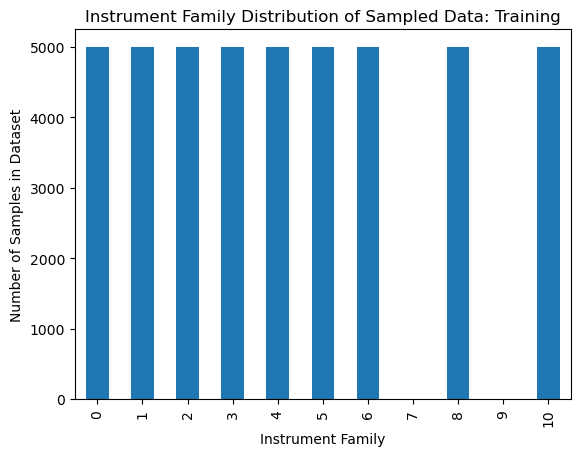

In [12]:
#Display instrument distrution
df_train_sample2['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train2), 1)).plot(kind='bar')
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [13]:
#save the train file index as list
filenames_train2 = df_train_sample2.index.tolist()

In [45]:
#save the list to a pickle file
with open('DataWrangling/filenames_train_rm.pickle', 'wb') as f:
    pickle.dump(filenames_train2, f)

In [15]:
#extract the filenames from the validation dataset
df_valid2 = pd.read_json(path_or_buf='nsynth-valid/examples.json', orient='index')
df_valid2 = df_valid2[df_valid2["instrument_family_str"] != 'reed']
print(df_valid2["instrument_family_str"].unique())
df_valid2.head()

['keyboard' 'bass' 'mallet' 'organ' 'brass' 'guitar' 'string' 'vocal'
 'flute']


,note_str,sample_rate,qualities_str,instrument_source,instrument_family_str,instrument_family,note,instrument_source_str,qualities,pitch,instrument_str,instrument,velocity
keyboard_acoustic_004-060-025,keyboard_acoustic_004-060-025,16000,"[dark, reverb]",0,keyboard,4,278915,acoustic,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",60,keyboard_acoustic_004,327,25
bass_synthetic_033-050-100,bass_synthetic_033-050-100,16000,[dark],2,bass,0,270361,synthetic,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",50,bass_synthetic_033,417,100
bass_synthetic_009-052-050,bass_synthetic_009-052-050,16000,"[bright, distortion, long_release]",2,bass,0,270001,synthetic,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0]",52,bass_synthetic_009,150,50
keyboard_electronic_003-064-127,keyboard_electronic_003-064-127,16000,[],1,keyboard,4,50978,electronic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",64,keyboard_electronic_003,65,127
bass_synthetic_034-030-050,bass_synthetic_034-030-050,16000,"[distortion, tempo-synced]",2,bass,0,265159,synthetic,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1]",30,bass_synthetic_034,420,50


In [16]:
#save the train file index as list
filenames_valid2 = df_valid2.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_valid_rm.pickle', 'wb') as f:
    pickle.dump(filenames_valid2, f)

In [17]:
df_valid2.shape

(11958, 13)

In [18]:
#extract the filenames from the testing dataset
df_test2 = pd.read_json(path_or_buf='nsynth-test/examples.json', orient='index')
df_test2 = df_test2[df_test2["instrument_family_str"] != 'reed']
print(df_test2["instrument_family_str"].unique())
df_test2.head()

['bass' 'keyboard' 'guitar' 'flute' 'string' 'vocal' 'brass' 'mallet'
 'organ']


,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_068-049-025,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,synthetic,25,bass_synthetic_068,656,16000,[dark],2,bass_synthetic_068-049-025,0,bass
keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard
guitar_acoustic_010-066-100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,acoustic,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar
flute_acoustic_002-077-100,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,acoustic,100,flute_acoustic_002,86,16000,[reverb],0,flute_acoustic_002-077-100,2,flute
string_acoustic_056-047-075,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",47,45336,acoustic,75,string_acoustic_056,436,16000,"[fast_decay, reverb]",0,string_acoustic_056-047-075,8,string


In [19]:
df_test2.shape

(3861, 13)

In [46]:
#save the train file index as list
filenames_test2 = df_test2.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_test_rm.pickle', 'wb') as f:
    pickle.dump(filenames_test2, f)

In [21]:
def feature_extract2(file):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

In [22]:
def instrument_code2(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard','organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

The function above can take a lot of time for large datasets. It is advisisable to start out on small samples to get an estimate of running time.

## Testing Set

In [23]:
#create dictionary to store all test features
dict_test2 = {}
#loop over every file in the list
for file2 in filenames_test2:
    #extract the features
    features2 = feature_extract2(test_dir2+ file2 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_test2[file2] = features2

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [24]:
#convert dict to dataframe
features_test2 = pd.DataFrame.from_dict(dict_test2, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_test2.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_068-049-025,1,"[-522.8658, 46.664146, 34.3798, 24.787592, 17....","[0.010030989, 0.02624286, 0.043270763, 0.09308...","[0.14551312, 0.82559353, 0.07650902, 0.0340558...","[35.980332057104036, 29.09879218811833, 27.842..."
keyboard_electronic_001-021-127,0,"[-444.64713, 193.89459, 27.29581, -3.6878698, ...","[0.055242054, 0.19966866, 11.731714, 20.330849...","[0.08902063, 0.10597091, 0.077824585, 0.392217...","[19.948747046905105, 19.841753347165195, 18.75..."
guitar_acoustic_010-066-100,0,"[-439.37473, 59.548584, 2.893683, -12.038998, ...","[0.0014635224, 0.0026336862, 0.0022025586, 0.0...","[0.10209415, 0.11988667, 0.064387664, 0.072573...","[12.37305152614007, 34.62256118413128, 35.3186..."
flute_acoustic_002-077-100,1,"[-365.42816, 13.425872, -43.5183, 20.321768, -...","[4.926747e-05, 0.0001282078, 0.00046132316, 0....","[0.07728491, 0.08046897, 0.073985286, 0.037789...","[20.51487418872989, 10.440352061701418, 40.267..."
string_acoustic_056-047-075,1,"[-507.2523, 41.686783, 19.495766, 13.723616, 1...","[0.0011634888, 0.00048329413, 0.01331722, 0.16...","[0.36978, 0.20055531, 0.13097511, 0.092079386,...","[22.120978925720166, 19.4485726008245, 18.4564..."


In [25]:
#extract mfccs
mfcc_test2 = pd.DataFrame(features_test2.mfcc.values.tolist(),index=features_test2.index)
mfcc_test2 = mfcc_test2.add_prefix('mfcc_')

#extract spectro
spectro_test2 = pd.DataFrame(features_test2.spectro.values.tolist(),index=features_test2.index)
spectro_test2 = spectro_test2.add_prefix('spectro_')


#extract chroma
chroma_test2 = pd.DataFrame(features_test2.chroma.values.tolist(),index=features_test2.index)
chroma_test2 = chroma_test2.add_prefix('chroma_')


#extract contrast
contrast_test2 = pd.DataFrame(features_test2.contrast.values.tolist(),index=features_test2.index)
contrast_test2 = chroma_test2.add_prefix('contrast_')

#drop the old columns
features_test2 = features_test2.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_test2=pd.concat([features_test2, mfcc_test2, spectro_test2, chroma_test2, contrast_test2],
                           axis=1, join='inner')
df_features_test2.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_068-049-025,1,-522.865784,46.664146,34.379799,24.787592,17.420424,10.198802,4.609534,1.380598,-1.023342,...,0.076509,0.034056,0.035498,0.025267,0.019353,0.038954,0.092328,0.087519,0.061090,0.091117
keyboard_electronic_001-021-127,0,-444.647125,193.894592,27.295811,-3.687870,6.295289,8.091359,10.286986,6.085114,2.499446,...,0.077825,0.392218,0.563529,0.143236,0.164834,0.211634,0.353580,0.422365,0.019230,0.009007
guitar_acoustic_010-066-100,0,-439.374725,59.548584,2.893683,-12.038998,-12.553400,-11.452487,-12.534291,-20.458334,-19.255125,...,0.064388,0.072573,0.091863,0.090990,0.840737,0.093613,0.048391,0.030883,0.015003,0.009667
flute_acoustic_002-077-100,1,-365.428162,13.425872,-43.518299,20.321768,-29.725790,-21.518467,-17.812229,-10.225934,8.543968,...,0.073985,0.037789,0.052419,0.910790,0.022027,0.030132,0.009579,0.028886,0.048302,0.016970
string_acoustic_056-047-075,1,-507.252289,41.686783,19.495766,13.723616,10.128812,6.166399,2.937203,2.337268,0.628674,...,0.130975,0.092079,0.049420,0.063888,0.190519,0.148201,0.114678,0.184953,0.227102,0.593137


In [26]:
targets_test2 = []
for name2 in df_features_test2.index.tolist():
    targets_test2.append(instrument_code2(name2))

df_features_test2['targets'] = targets_test2

In [47]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_test_rm.pickle', 'wb') as f:
    pickle.dump(df_features_test2, f)

In [28]:
df_features_test2.shape

(3861, 167)

## Traning Set

In [29]:
start_train2 = time.time()

#create dictionary to store all test features
dict_train2 = {}
#loop over every file in the list
for file2 in filenames_train2:
    #extract the features
    features2 = feature_extract2(train_dir2 + file2 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_train2[file2] = features2

end_train2 = time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train2), end_train2 - start_train2))

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Time to extract 45000 files is 32080.080765485764 seconds


In [38]:
#convert dict to dataframe
features_train2 = pd.DataFrame.from_dict(dict_train2, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_train2.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_142-049-127,0,"[-515.7289, 53.332275, 37.22874, 25.681623, 14...","[0.6968942, 0.025184862, 0.027261028, 0.078671...","[0.16311885, 0.8324105, 0.053889677, 0.0150975...","[33.71074215936831, 22.372186850863596, 29.639..."
bass_synthetic_122-084-127,1,"[-514.64246, 44.909332, 13.159913, 7.293651, 3...","[0.2578344, 0.006803379, 0.0026043286, 0.01102...","[0.4359914, 0.34951353, 0.32076564, 0.12160426...","[28.23427588464891, 22.86607574484116, 21.4583..."
bass_electronic_009-052-075,0,"[-531.13495, 47.113785, 33.119278, 28.952318, ...","[0.07705308, 0.35188174, 2.9322045, 5.2556624,...","[0.05447634, 0.063362405, 0.09374732, 0.109784...","[31.264087177668564, 22.400254821640317, 25.82..."
bass_synthetic_124-060-050,1,"[-295.9483, 105.86739, -11.24913, 2.6563392, 0...","[0.751299, 0.18457669, 0.20050567, 0.25559327,...","[0.79038286, 0.20670041, 0.12100229, 0.0887064...","[23.08349423255505, 22.615925756499514, 28.237..."
bass_synthetic_037-084-127,1,"[-434.64835, 17.221346, -18.895113, -18.721144...","[3.7978237, 0.039691422, 0.014414316, 0.008560...","[0.9989825, 0.00917061, 0.0046140924, 0.003350...","[37.28558502089323, 13.985240892468385, 16.212..."


In [39]:
#extract mfccs
mfcc_train2 = pd.DataFrame(features_train2.mfcc.values.tolist(),
                          index=features_train2.index)
mfcc_train2 = mfcc_train2.add_prefix('mfcc_')

#extract spectro
spectro_train2 = pd.DataFrame(features_train2.spectro.values.tolist(),
                             index=features_train2.index)
spectro_train2 = spectro_train2.add_prefix('spectro_')


#extract chroma
chroma_train2 = pd.DataFrame(features_train2.chroma.values.tolist(),
                            index=features_train2.index)
chroma_train2 = chroma_train2.add_prefix('chroma_')


#extract contrast
contrast_train2 = pd.DataFrame(features_train2.contrast.values.tolist(),
                              index=features_train2.index)
contrast_train2 = chroma_train2.add_prefix('contrast_')

#drop the old columns
features_train2 = features_train2.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_train2=pd.concat([features_train2, mfcc_train2, spectro_train2, chroma_train2, contrast_train2],
                           axis=1, join='inner')
df_features_train2.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_142-049-127,0,-515.728882,53.332275,37.228741,25.681623,14.605336,6.805699,4.136306,4.529160,5.349216,...,0.053890,0.015098,0.020915,0.018028,0.004079,0.059172,0.072921,0.056718,0.068520,0.070115
bass_synthetic_122-084-127,1,-514.642456,44.909332,13.159913,7.293651,3.194368,15.163963,30.435987,29.094479,13.916428,...,0.320766,0.121604,0.067751,0.090599,0.427149,0.406163,0.089121,0.025346,0.067192,0.057793
bass_electronic_009-052-075,0,-531.134949,47.113785,33.119278,28.952318,21.222887,14.516416,8.166193,3.469417,-0.093293,...,0.093747,0.109784,0.854280,0.108246,0.088342,0.049128,0.054983,0.089429,0.058422,0.064306
bass_synthetic_124-060-050,1,-295.948303,105.867393,-11.249130,2.656339,0.186966,-11.605272,-17.057228,-17.663654,-13.395882,...,0.121002,0.088706,0.123688,0.066821,0.104290,0.311894,0.064751,0.055910,0.088896,0.164815
bass_synthetic_037-084-127,1,-434.648346,17.221346,-18.895113,-18.721144,-14.262136,5.839556,27.351156,30.501577,8.236714,...,0.004614,0.003350,0.003350,0.003350,0.003350,0.004481,0.002242,0.002297,0.003561,0.006986


In [40]:
targets_train2 = []
for name2 in df_features_train2.index.tolist():
    targets_train2.append(instrument_code2(name2))

In [41]:
df_features_train2['targets'] = targets_train2

In [48]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_train_rm.pickle', 'wb') as f:
    pickle.dump(df_features_train2, f)

In [43]:
df_features_train2.shape

(45000, 167)

## Validation Set

In [44]:
start_valid2 = time.time()

#create dictionary to store all test features
dict_valid2 = {}
#loop over every file in the list
for file2 in filenames_valid2:
    #extract the features
    features2 = feature_extract2(valid_dir2+ file2 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_valid2[file2] = features2

end_valid2=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid2), end_valid2 - start_valid2))

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Time to extract 11958 files is 5576.683756113052 seconds


In [49]:
#convert dict to dataframe
features_valid2 = pd.DataFrame.from_dict(dict_valid2, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_valid2.head()

,harmonic,mfcc,spectro,chroma,contrast
keyboard_acoustic_004-060-025,1,"[-475.23547, 57.881565, 45.41308, 33.631557, 2...","[1.1800027, 2.7473865, 0.97745705, 2.6299975, ...","[0.7166769, 0.118479714, 0.11610127, 0.0989934...","[20.83616053735028, 29.13231210190147, 28.2069..."
bass_synthetic_033-050-100,1,"[-423.16907, 69.13418, 45.36877, 22.640656, 8....","[2.3157597, 0.02870563, 0.035071626, 0.1275377...","[0.10281316, 0.12115274, 0.8339974, 0.21695851...","[30.731925079555808, 29.642553887634914, 32.86..."
bass_synthetic_009-052-050,0,"[-151.4592, 56.180984, -52.366467, 74.293594, ...","[0.819314, 0.022450991, 0.012858832, 0.0213032...","[0.0009446367, 0.0, 0.0019586482, 0.054268196,...","[32.36749747896233, 30.655247758435255, 34.711..."
keyboard_electronic_003-064-127,0,"[-500.15427, 47.05853, 13.788354, 8.744275, 3....","[0.00067951076, 0.0030120846, 0.016500076, 0.0...","[0.0, 0.0, 0.0009528077, 0.079969384, 0.775525...","[17.152303256722128, 29.867041144449978, 30.17..."
bass_synthetic_034-030-050,1,"[-411.7628, 67.75837, 38.892403, 56.140118, 24...","[0.96107304, 4.6424894, 84.44767, 434.86514, 8...","[0.046644557, 0.39849162, 0.026936369, 0.01650...","[28.739367387266007, 20.733264721175146, 20.37..."


In [50]:
#extract mfccs
mfcc_valid2 = pd.DataFrame(features_valid2.mfcc.values.tolist(),
                          index=features_valid2.index)
mfcc_valid2 = mfcc_valid2.add_prefix('mfcc_')

#extract spectro
spectro_valid2 = pd.DataFrame(features_valid2.spectro.values.tolist(),
                             index=features_valid2.index)
spectro_valid2 = spectro_valid2.add_prefix('spectro_')


#extract chroma
chroma_valid2 = pd.DataFrame(features_valid2.chroma.values.tolist(),
                            index=features_valid2.index)
chroma_valid2 = chroma_valid2.add_prefix('chroma_')


#extract contrast
contrast_valid2 = pd.DataFrame(features_valid2.contrast.values.tolist(),
                              index=features_valid2.index)
contrast_valid2 = chroma_valid2.add_prefix('contrast_')

#drop the old columns
features_valid2 = features_valid2.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_valid2=pd.concat([features_valid2, mfcc_valid2, spectro_valid2, chroma_valid2, contrast_valid2],
                           axis=1, join='inner')
df_features_valid2.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
keyboard_acoustic_004-060-025,1,-475.235474,57.881565,45.413078,33.631557,23.860250,16.503078,11.231784,6.607216,2.438399,...,0.116101,0.098993,0.212848,0.251691,0.214841,0.128957,0.139373,0.083054,0.056506,0.099800
bass_synthetic_033-050-100,1,-423.169067,69.134178,45.368771,22.640656,8.431941,1.126918,-2.505025,-3.276568,-2.163706,...,0.833997,0.216959,0.059687,0.037414,0.035974,0.023575,0.001356,0.263913,0.016409,0.035910
bass_synthetic_009-052-050,0,-151.459198,56.180984,-52.366467,74.293594,-48.825958,37.103230,-37.218937,17.417768,-20.727285,...,0.001959,0.054268,0.890012,0.049923,0.000945,0.000000,0.113582,0.000000,0.000000,0.434298
keyboard_electronic_003-064-127,0,-500.154266,47.058529,13.788354,8.744275,3.266100,-1.396002,-5.341508,-7.094386,-8.291027,...,0.000953,0.079969,0.775525,0.114564,0.052765,0.166308,0.116658,0.088980,0.002495,0.048147
bass_synthetic_034-030-050,1,-411.762787,67.758369,38.892403,56.140118,24.529562,26.548122,12.209658,12.024644,6.558580,...,0.026936,0.016504,0.055768,0.282189,0.750071,0.150681,0.031391,0.028311,0.036247,0.028427


In [51]:
targets_valid2 = []
for name2 in df_features_valid2.index.tolist():
    targets_valid2.append(instrument_code(name2))

df_features_valid2['targets'] = targets_valid2

NameError: name 'instrument_code' is not defined

In [ ]:
df_features_valid2.shape

In [ ]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_valid_rm.pickle_rm', 'wb') as f:
    pickle.dump(df_features_valid2, f)

# Clean JSON Files

In [ ]:
#extract qualities
train_qual2 = pd.DataFrame(df_train_sample2.qualities.values.tolist(), index= df_train_sample2.index)


#concatenate
json_train2=pd.concat([df_train_sample2, train_qual2],
                           axis=1, join='inner')

json_train2= json_train2.drop(labels=['qualities'], axis=1)
json_train2.head()

In [ ]:
#save the dataframe to a pickle file
with open('DataWrangling/json_train_rm.pickle', 'wb') as f:
    pickle.dump(json_train2, f)

In [ ]:
#extract qualities
test_qual2 = pd.DataFrame(df_test2.qualities.values.tolist(), index= df_test2.index)


#concatenate
json_test2=pd.concat([df_test2, test_qual2],
                           axis=1, join='inner')

json_test2= json_test2.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_test_rm.pickle', 'wb') as f:
    pickle.dump(json_test2, f)

In [ ]:
#extract qualities
valid_qual2 = pd.DataFrame(df_valid2.qualities.values.tolist(), index= df_valid2.index)


#concatenate
json_valid2=pd.concat([df_valid2, valid_qual2],
                           axis=1, join='inner')

json_valid2= json_valid2.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_valid_rm.pickle', 'wb') as f:
    pickle.dump(json_valid2, f)